<a id='ReturntoTop'></a>


<header>
  <div style="display:flex; align-items:center;">
    <div style="flex-grow:1;">
      <h1>NLP with Steam Video Game Reviews</h1>
      <h3>Notebook 3 - Data Splitting and Tokenization </h3>
      <p>Author: David Lappin | Date: 5/12/2023 - 7/24/2023 </p>
    </div>
    <img src="bannerphoto/banner.jpg" alt="your-image-description" style="height:225px; margin-left:50px; border: 8px solid black;border-radius: 5%;">
  </div>
</header>

------------------------------------------------------------------------------------------------------------------------------

# Introduction and Purpose

Text tokenization is a fundamental step that breaks down a segment (in our case a review), into smaller units such as phrases, words, even characters called 'tokens'. By doing this, we will be creating a structured and uniform dataset that can be easily be interpreted by our models.

**In this notebook we will:**
- Re-clean and process our reviews
- Tokenize our dataset with a Bag of Words Model
- Split and save our newly cleaned and tokenized data set into testing and training sets


# Table of Contents

[Packages Import](#1)

[Data Import](#2)

[Text Cleaning and Prep](#3)

[Tokenization with Bag of Words Model](#4)

[Splitting Data Set](#5)

[Summary and Next Steps](#6)


# Packages Import
<a id='1'></a>
[Return to Top](#ReturntoTop)

**Matplotlib** - Used as needed for basic visualizations

**Numpy** - Supports large, multi-dimensional arrays and matrices,and contains a large collection of high-level mathematical functions to operate on these arrays.

**Pandas** - Additional data manipulation and analysis

**sklearn** - machine learning library

**seaborn** - graphing and visualization package

**nltk.corpus stopwords** - allows for the removal of english stop words (a, an, am, for....ect) in the user reviews

**nltk.stem PorterStemmer** - removing the commoner morphological and inflexional endings from words in English. 

**nltk WordNetLemmatizer** - reduces a word to its base or dictionary form

**re** - regex expression support

**nltk.stem SnowballStemmer** - reduces a word to its base or dictionary form

**train_test_split** - used to split data set into training/validation/and testing sets

**CountVectorizer** - used to created bag of words model and fit it to the reviews column


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk_metrics

#text cleaning 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.stem import SnowballStemmer

#tokenization and splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Data Import
[Return to Top](#ReturntoTop)
<a id='2'></a>

Import the reviews csv and explore some of the data within:

In [3]:
#import data

raw_df = pd.read_csv('data/train.csv')
raw_df.head(10)

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
5,6,Spooky's Jump Scare Mansion,2015.0,"Early Access ReviewIt's pretty cute at first, ...",1
6,7,Spooky's Jump Scare Mansion,2017.0,Great game. it's a cute little horror game tha...,1
7,8,Spooky's Jump Scare Mansion,2015.0,Spooky's Jump Scare Mansion is a Free Retro ma...,1
8,9,Spooky's Jump Scare Mansion,2015.0,"Somewhere between light hearted, happy parody ...",0
9,10,Spooky's Jump Scare Mansion,2015.0,This game with its cute little out of the wall...,1


The looks like it loaded correctly.

In [4]:
#replaces all values in the user review column that start with "Early Access Review" with Nan
#Note: the '^' indicates "begins with" and the '.*' at the end indicates "followed by any characters"
#regex=True ensures that the replacement is applied using regular expression matching

raw_df['user_review'] = raw_df['user_review'].replace(r'^Early Access Review.*', np.nan, regex=True)

In [5]:
#confirm drop values

raw_df.dropna(subset=['user_review'], inplace=True)

In [13]:
#check for Nan values in user_review column

print(f"There are {raw_df['user_review'].isnull().sum()} remaining Null Values")

#check the new length of the dataframe

print(f'The length of the remaining Dataset is: {len(raw_df)}')

There are 0 remaining Null Values
The length of the remaining Dataset is: 11761


# Text Cleaning and Prep

[Return to Top](#ReturntoTop)
<a id='3'></a>

We are going to quickly re-clean the data set as we did in the previous notebook. I have eliminated most of the mark-up for this file. If more detail is needed on this section please refer to Notebook: '2.0_DataCleaning_and_Prep'

In general, the code below seeks to define text cleaning functions for the following:
- Removal of unwanted symbols, emojis, spaces, numbers and punctuation
- Removal of English Stop words
- Reducing words to their root form via 'Stemming'

**Source - https://www.kaggle.com/code/danielbeltsazar/steam-games-reviews-analysis-sentiment-analysis**

In [14]:
#removes any hyperlinks or random markups from reviews
#links to other sites are not relevant to the text we are working with 

def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result


#removes digits so that all you are left with is characters text

def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output


#removes emojis and symbols

def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)


#removes additional white spaces

def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 


#removes any remaining symbols

def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string


#Removes punctuation marks

def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final



#removes english stop words

stop=set(stopwords.words("english"))
#stemmer=PorterStemmer()
#lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)



#applies stemming if desired


#def Stemming(text):
   #stem=[]
   #stopword = stopwords.words('english')
   #snowball_stemmer = SnowballStemmer('english')
   #word_tokens = nltk.word_tokenize(text)
   #stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   #stem=' '.join(stemmed_word)
   #return stem



In [15]:
#defines a cleaning function to incorporate all functions above given the dataframe and column name

def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    #df[review] = df[review].apply(Stemming)

We can now go ahead and implement all the cleaning functions on our data set:

In [16]:
#clean user review column 

cleaning(raw_df,'user_review')


Lets look at a selection of our now cleaned texts:

In [17]:
for x in raw_df['user_review'].sample(n=10, random_state=1001):
    print(x)
    print('\n')

started playing creativerse two years ago started playing close halloween playing creativerse saw ghost leafi confused never seen went killed walked hill saw like okay halloween went tamed one brought back workshop named ghosty halloween event sad ghost leafi ghost creatures wish creativerse kept ghost creatures great nightime creatures halloween although getting close halloween year hoping bring back creativerse still great game


learning curve steep first hrs dying non stop maybe happened suck get hang really enjoy game amazed see good quality free play actually fp pay wini played light assault time like jetpacks say sure every class feels different unique guns unique even guns differ stats feel different higby awesome need good enough rig play upgrade gb ram run smoothly much wrongi see people complaining interaction devs guess thats kind con dont care much dev interactionsfinal word addicted


lacks atmosphere kiddie art direction wannabe wow graphically hand holding quest sparkle

### Observations

We can see from the sample above that we have cleaned up the reviews considerably. There are no longer early access reviews, and all of the extraneous symbols and punctuations are removed. The spaces are uniform and the reviews are ready to tokenized. 

Lets create and dataframe called 'cleaned_df' before we continue so that we can differentiate between our uploaded raw file and our new cleaned dataframe.

In [68]:
#create new file 

clean_df = raw_df.copy().reset_index(drop = True)

In [69]:
#sanity check

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11761 entries, 0 to 11760
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        11761 non-null  int64  
 1   title            11761 non-null  object 
 2   year             11583 non-null  float64
 3   user_review      11761 non-null  object 
 4   user_suggestion  11761 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 459.5+ KB


# Tokenization with Bag of Words Model

[Return to Top](#ReturntoTop)
<a id='4'></a>

The Bag of Words model (BoW) is a simple yet effective representation model for sentiment analysis. It lacks some complexity in that it does not retain sequence information or sentence context. There are more advanced word embedding techniques to determine word relations, but for this project we will utilize a simplified representation of the user reviews.

#### *Notes on min_df parameter*

We adjusted the min_df parameter below to reduce the amount of tokens by excluding words that only appeared in only 1.0% of entries. Meaning, if the words were extremely rare, they were not created as tokens. This parameter could be adjusted further to reduce the size and dimentionality of the final dataframes if needed for modeling. We would have to keep in mind that this is removing data though.

In [59]:
#create bag of words count vectorizer 

# 1. Instantiate

# We are including a min_df of 0.01 to ignore tokens appearing in less than 1% of the documents
bagofwords = CountVectorizer(min_df = 0.01) 

# 2. Fit to dataset
bagofwords.fit(clean_df['user_review'])

# 3. Transform
clean_df_transform = bagofwords.transform(clean_df['user_review'])

We can look and see what we have:

In [60]:
clean_df_transform

<11761x1045 sparse matrix of type '<class 'numpy.int64'>'
	with 427163 stored elements in Compressed Sparse Row format>

Though it shows the dimensionality above we can explicitly see how many tokens were created with our bag of words model:

In [61]:
len(bagofwords.get_feature_names())

C:\Users\dlapp\anaconda3\envs\baseclone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1045

Next we can re-create the data frame by transforming the sparse matrix back to array and then to a pandas data frame:

In [62]:
#Re-create the df

tok_df_array = clean_df_transform.toarray()
temp_tok_df = pd.DataFrame(data=tok_df_array, columns = bagofwords.get_feature_names())
temp_tok_df

,abilities,ability,able,absolute,absolutely,access,account,across,action,active,...,wrong,ww,xp,yeah,year,years,yes,yet,youtube,yu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11757,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
11759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Observations

Looks like the transformation worked successfully and the dimensionality of the temporary data frame is as predicted based on the sparse matrix above. 

We can then combine the `user_suggestion` column from the original data back in by creating a temporary data frame with just that column and concatenating it with the new tokenized data frame:

In [70]:
#drop unwanted columns 

temp_clean_df = clean_df.drop(columns = ['review_id', 'title', 'year', 'user_review'], inplace = False)

In [73]:
#sanity check 

temp_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11761 entries, 0 to 11760
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   user_suggestion  11761 non-null  int64
dtypes: int64(1)
memory usage: 92.0 KB


Now combine the two:

In [85]:
#combine the two temporary files

tok_df = pd.concat([temp_clean_df, temp_tok_df], axis=1)

In [92]:
#looka t new dataframe to ensure it is correct

tok_df

,user_suggestion,abilities,ability,able,absolute,absolutely,access,account,across,action,...,wrong,ww,xp,yeah,year,years,yes,yet,youtube,yu
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11756,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11757,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11758,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
11759,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Observations:
Looks good and ready to be split into training and testing data:

# Splitting Data Set

[Return to Top](#ReturntoTop)
<a id='5'></a>

Firstly lets look back to see how our data is balanced between positive and negative reviews so we can determine how best to split the data. We can do a count of the reviews by using the suggestion column:

In [88]:
print(f"There are {len(tok_df['user_suggestion'])} total reviews (both positive and negative)") 
print('\n')

print(f"There are {tok_df['user_suggestion'].sum()} positive reviews")
print('\n')

print(f"There are {len(tok_df['user_suggestion']) - tok_df['user_suggestion'].sum()} negative reviews")   

There are 11761 total reviews (both positive and negative)


There are 6677 positive reviews


There are 5084 negative reviews


We can also visualize these numbers:

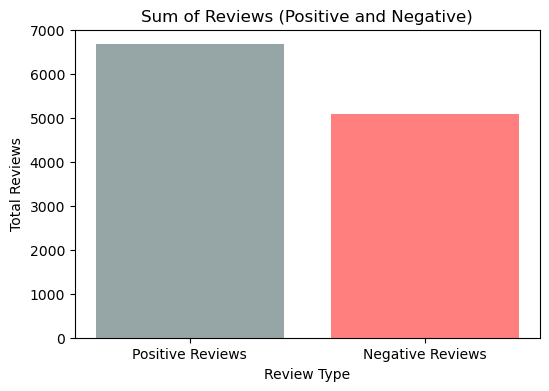

In [89]:
lenpositive = tok_df['user_suggestion'].sum()
lennegative = len(tok_df['user_suggestion']) - tok_df['user_suggestion'].sum()


# set figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the sum of positive and sum of neagtive as bars
ax.bar('Positive Reviews', lenpositive, color='darkslategray', alpha = 0.50)
ax.bar('Negative Reviews', lennegative, color='red', alpha = 0.50)

# labels and titles
ax.set_xlabel('Review Type')
ax.set_ylabel('Total Reviews')
ax.set_title('Sum of Reviews (Positive and Negative)')

# Show the plot
plt.show()

### Observations:

We can see that after removing the 'Early Access Reviews' our data balance has not shifted much. As before, there are still fewer negative reviews than positive reviews in the dataset. They are not massively different however and so for the purposes of this project we will proceed to split the data in the following manner:

- Split data into Training and test to reserve some data for testing in the future (stratify on `user suggestion` to maintain balance.
- Split the training data into positive and negative reviews
- split each subset (positive vs. negative) separately into training and validation sets
- Combine the train sets for positive and negative reviews
- Combine the test sets for positive and negative reviews

In this way, we will maintain the class balance observed above in both the training and testing sets for the positive and negative reviews.

Firstly we can reserve some data into the testing set.

In [103]:
#creates a training and test set 
#note we are stratifying on `user_suggestion`

train_df, test_df = train_test_split(tok_df, test_size=0.1, stratify=tok_df['user_suggestion'], random_state=7)

We can at this point save the train and test sets. Normally I would not save additional files but since we are working across multiple notebooks, we can save the data to new .csv files. We will split the training data into training and validation sets prior to modeling. 

>***You can skip this step but you must ensure that all data is the same when training models or the results will either be inconsistent or at risk of data leakage.***

In [107]:
# saves file to data folder - adjust file path as needed

#test_df.to_csv('data/test_df.csv', index = False)

In [130]:
# saves file to data folder - adjust file path as needed

#train_df.to_csv('data/train_df.csv', index = False)

As a last step before moving on to modeling, lets ensure that the stratification in the test_train_split worked correctly and the ratio between positive and negative reviews was preserved.

Lets modify the code from above to do some basic arithmetic and see:

In [155]:
#unsplit data

print(f"The negative to positive ratio for the unsplit data is: {round((len(tok_df['user_suggestion']) - tok_df['user_suggestion'].sum()) / tok_df['user_suggestion'].sum(), 4)}")
print('\n')

#train set split

print(f"The negative to positive ratio for the train split is: {round((len(train_df['user_suggestion']) - train_df['user_suggestion'].sum()) / train_df['user_suggestion'].sum(), 4)}") 
print('\n')

#test set split

print(f"The negative to positive ratio for the test split is: {round((len(test_df['user_suggestion']) - test_df['user_suggestion'].sum()) / test_df['user_suggestion'].sum(), 4)}") 


The negative to positive ratio for the unsplit data is: 0.7614


The negative to positive ratio for the train split is: 0.7614


The negative to positive ratio for the test split is: 0.762


### Observations 

As we can see, the ratio between the positive and negative reviews is nearly identical for the original and the test/train subsets. The stratify parameter worked to effectively preserve the data balance.

------------------------------------------------------------------------------------------------------------------------------

# Summary and Next Steps:
<a id='6'></a>
[Return to Top](#ReturntoTop)

**From the Data Splitting and Tokenization we found the following out and completed the following tasks for our dataset:**
- Utilized the cleaning tools from the previous notebook to clean our data set
- Tokenized our data set using a BoW model. Used a `min_df` of 0.01 to remove tokens that were present in less than 1% of reviews. This helped to reduce our dimensionality. 
 

**Next Steps: (Baseline Modeling)**
- Next we will explore various modeling techniques and evaluate some of the best options for predicting sentiment analysis in this data set

    

### Next steps are located in the Third Notebook - '4.0_Exploratory_Modeling'